In [1]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
from helpers import Trade, generate_random_hex_color
import os
import sys
import seaborn as sns

plt.style.use('Solarize_Light2')

- Loading constants

In [2]:
import json

with open('global.params.json', 'r') as file:
    PARAMS = json.load(file)

TICKERS = PARAMS['Tickers']
FIGSIZE = PARAMS['FIGSIZE']
SIGNALS = PARAMS['SIGNALS']
POSITIONS_NATURE = PARAMS['POSITIONS_NATURE']
POSITIONS_SHORTCUT = PARAMS['POSITIONS_SHORTCUT']

- load & clean data

In [3]:
tickers_list = [tk for tk in TICKERS]

if os.path.exists("global-data.csv"):
    df = pd.read_csv("global-data.csv")
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
else:
    data = {}
    for ticker in TICKERS:
        data[ticker] = yf.Ticker(ticker).history(period="max", interval='1h')
    for ticker in data:
        data[ticker].drop(columns=['Volume', 'Stock Splits', 'Dividends'], inplace=True)
        data[ticker]['Ticker'] = ticker
        data[ticker].reset_index(inplace=True)
        data[ticker].columns = data[ticker].columns.str.lower()
    df = pd.concat([data[tk] for tk in tickers_list])
    df.to_csv("global-data.csv")

df.set_index(['datetime', 'ticker'], inplace=True)
df = df[['open','high','low','close']]

df.sort_index(ascending=True, inplace=True)

In [4]:
df.head(len(tickers_list) * 2)

open          high           low  \
datetime                  ticker                                             
2022-10-14 10:00:00-04:00 GC=F     1656.300049   1658.500000   1651.000000   
                          NQ=F    11052.500000  11054.250000  10852.750000   
                          YM=F    30270.000000  30270.000000  29808.000000   
2022-10-14 11:00:00-04:00 GC=F     1654.800049   1657.099976   1650.199951   
                          NQ=F    10917.250000  10971.500000  10826.500000   
                          YM=F    29965.000000  30067.000000  29804.000000   

                                         close  
datetime                  ticker                
2022-10-14 10:00:00-04:00 GC=F     1654.699951  
                          NQ=F    10917.000000  
                          YM=F    29960.000000  
2022-10-14 11:00:00-04:00 GC=F     1650.300049  
                          NQ=F    10832.750000  
                          YM=F    29828.000000

- stop if there is missing data

In [5]:
bool_df = df.isna()
if not bool_df.loc[(bool_df['close'] == True) | (bool_df['high'] == True) | (bool_df['low'] == True) | (bool_df['open'] == True)].empty:
    print("There is missing data")
    sys.exit("There is missing data")

In [6]:
# df.shape

# Creating needed cols

In [7]:
WINDOW = 31

df['Mean'] = df.groupby(level=1)['close'].transform(lambda grouped: grouped.rolling(window=TICKERS[grouped.name]['WINDOW']).mean())
# df["EMA"] = df.groupby(level=1)['close'].transform(lambda grouped: grouped.ewm(span=TICKERS[grouped.name]['WINDOW'], adjust=False).mean())
df['STD'] = df.groupby(level=1)['close'].transform(lambda grouped: grouped.rolling(window=TICKERS[grouped.name]['WINDOW']).std())

df['Z-Score'] = np.where(
    abs(df['high'] - df['Mean'])  > abs(df['Mean'] - df['low']),
    (df['high'] - df['Mean']) / df['STD'],
    (df['low'] - df['Mean']) / df['STD']
)

df['Mean'] = df.groupby(level=1)['Mean'].shift(1)
df['STD'] = df.groupby(level=1)['STD'].shift(1)
df['Z-Score'] = df.groupby(level=1)['Z-Score'].shift(1)

df.dropna(inplace=True)

print(df.shape)

(34165, 7)


In [8]:
df.head(len(tickers_list) * 2)

open      high       low     close  \
datetime                  ticker                                           
2022-10-17 08:00:00-04:00 NQ=F    10900.50  10950.25  10875.50  10944.25   
                          YM=F    30006.00  30059.00  29964.00  30043.00   
2022-10-17 09:00:00-04:00 NQ=F    10944.50  11116.75  10944.25  11073.50   
                          YM=F    30047.00  30361.00  30045.00  30174.00   
2022-10-17 10:00:00-04:00 NQ=F    11074.25  11133.25  11027.25  11047.00   
                          YM=F    30178.00  30313.00  30072.00  30113.00   

                                          Mean         STD   Z-Score  
datetime                  ticker                                      
2022-10-17 08:00:00-04:00 NQ=F    10825.226190   51.343750  1.660841  
                          YM=F    29858.095238   95.246472  1.815340  
2022-10-17 09:00:00-04:00 NQ=F    10826.523810   54.052053  2.289019  
                          YM=F    29862.047619  101.221280  1.945761  
2022-10-17 10:00:00-04:00 NQ=F    10837.988095   76.364565  3.650409  
                          YM=F    29878.523810  121.525561  3.970162

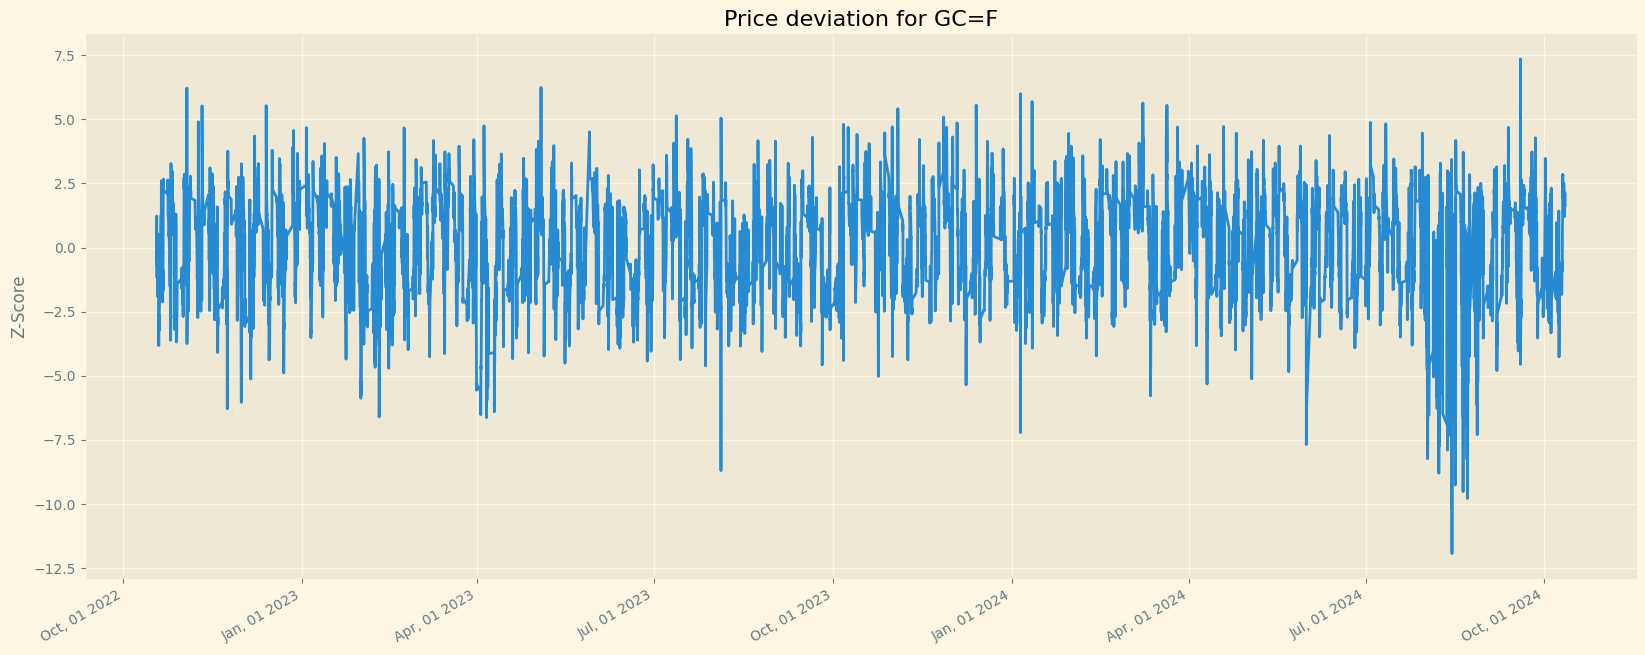

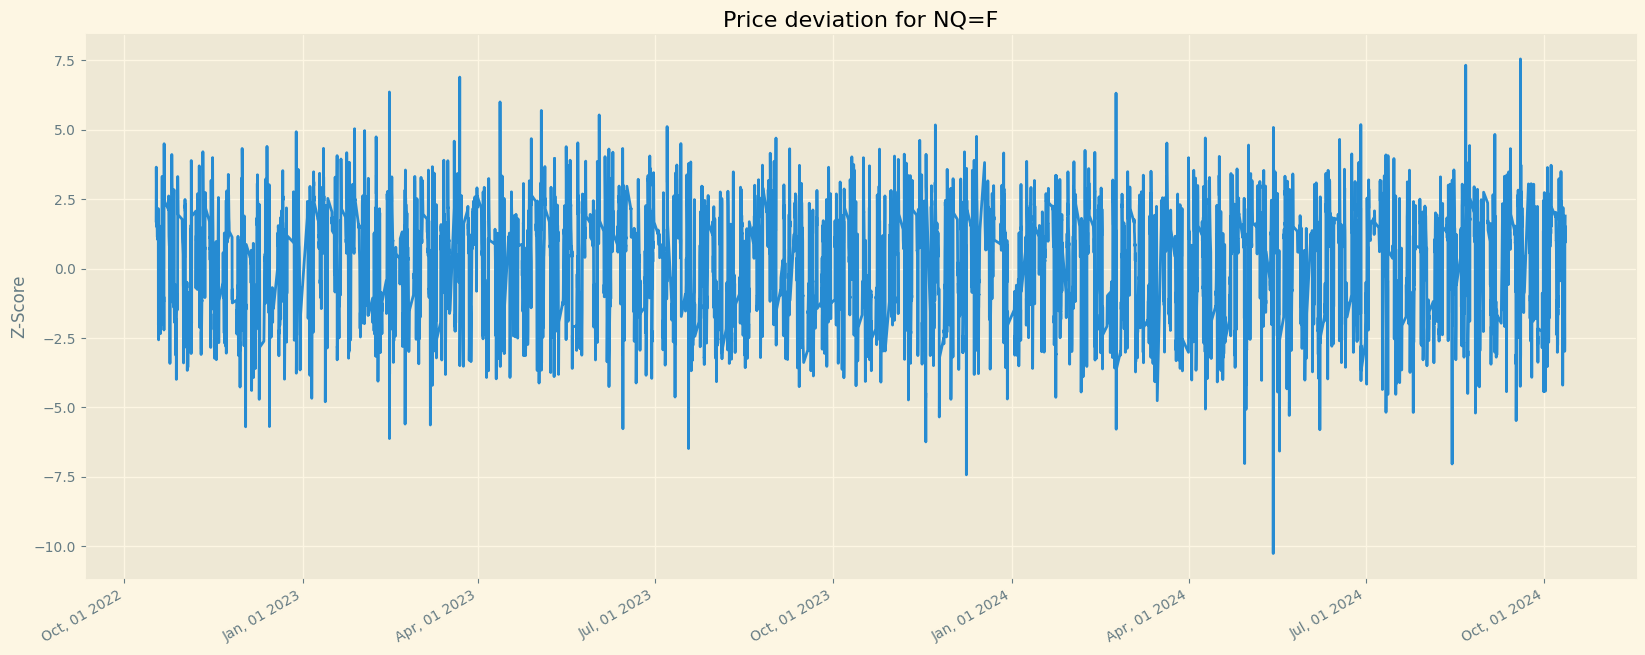

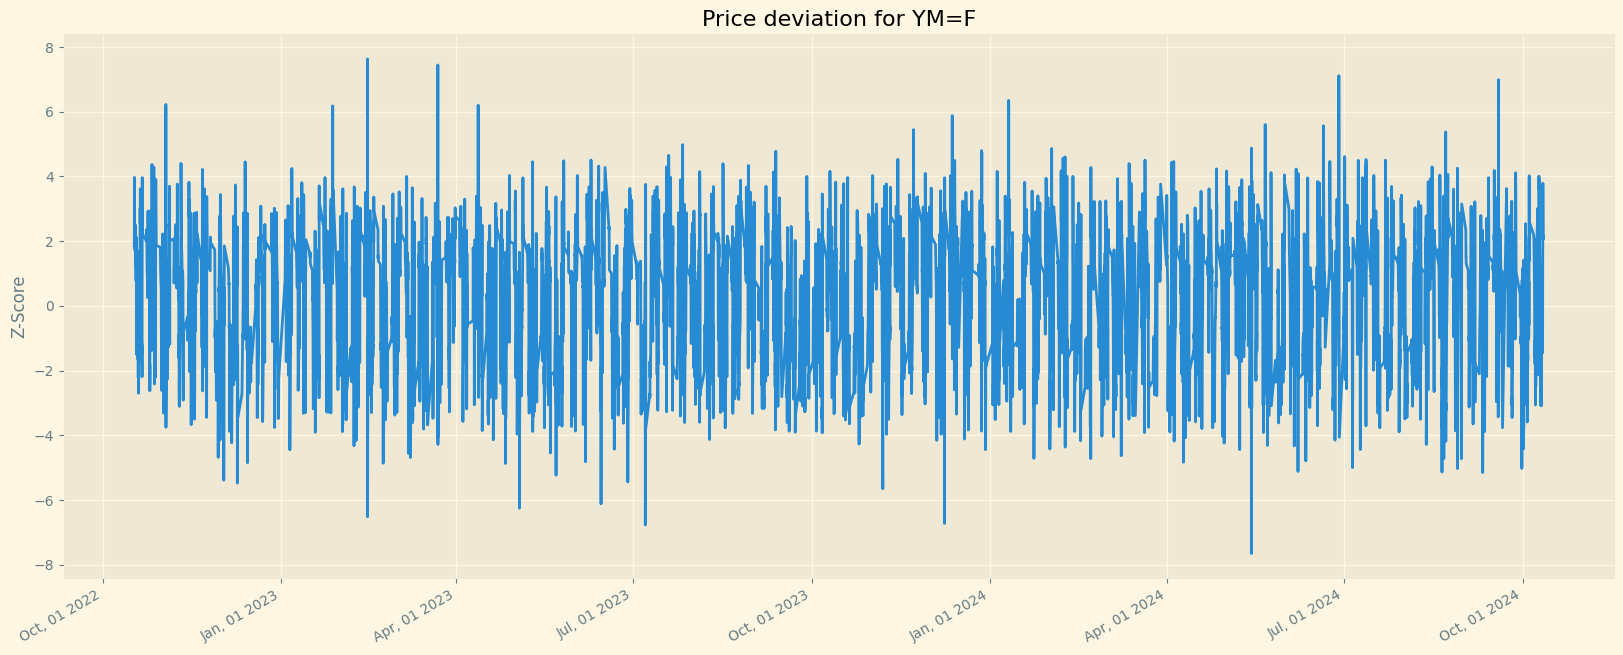

In [9]:
for name, group in df.groupby(level=1)['Z-Score']:
    group.index = [dt for (dt, _) in group.index]
    group.plot(kind='line', xlabel='', ylabel="Z-Score", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] + 3), title=f'Price deviation for {name}')

    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))

    plt.show()

# Generating Buy/Sell signals

In [10]:
df['Signal'] = 0  # Default to hold/no position

# df.xs('GC=F', level=1)['Z-Score']

for name  in TICKERS:
    price_deviate_over_xSTD_filter = (df.index.get_level_values('ticker') == name) & (df['Z-Score'] > TICKERS[name]['HIGHER_PRICE_DEVIATION']['ENTRY'])
    price_deviate_under_xSTD_filter = (df.index.get_level_values('ticker') == name) & (df['Z-Score'] < -TICKERS[name]['LOWER_PRICE_DEVIATION']['ENTRY'])

    df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
    df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# Implementing Stop Loss and Take Profit

In [11]:
# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trades = {}
for tk in TICKERS:
    trades[tk] = Trade()

def exit_trade(idx, is_win: bool):
    (_, ticker) = idx
    df.loc[idx, 'Exit_Price'] = trades[ticker].tp if is_win else trades[ticker].sl
    pnl = trades[ticker].rrr if is_win else -1
    df.loc[idx, ['PnL', 'Position']] = [pnl, SIGNALS['BUY' if trades[ticker].is_buy else 'SELL']]
    return True

def is_buy_sl(idx):
    (_, ticker) = idx
    if df.loc[idx, 'low'] <= trades[ticker].sl: return exit_trade(idx, False)
    return False

def is_buy_tp(idx, source='high'):
    (_, ticker) = idx
    if df.loc[idx, source] > trades[ticker].tp: return exit_trade(idx, True)
    return False

def is_sell_sl(idx):
    (_, ticker) = idx
    if df.loc[idx, 'high'] >= trades[ticker].sl: return exit_trade(idx, False)
    return False

def is_sell_tp(idx, source='low'):
    (_, ticker) = idx
    if df.loc[idx, source] < trades[ticker].tp: return exit_trade(idx, True)
    return False

# [NB] check SL first then make sure trade is On to check TP

def fill_trade_params(_row, idx):
    (_, ticker) = idx
    trade_signal = _row['Signal']

    is_long = (trade_signal == SIGNALS['BUY'])

    trades[ticker].On()
    DEVIATION = TICKERS[ticker]['LOWER_PRICE_DEVIATION'] if is_long else TICKERS[ticker]['HIGHER_PRICE_DEVIATION']
    trades[ticker].entry = (_row['Mean'] - trade_signal * DEVIATION['ENTRY'] * _row['STD'])
    trades[ticker].tp = (_row['Mean'] - trade_signal * DEVIATION['TP'] * _row['STD'])
    trades[ticker].sl = (_row['Mean'] - trade_signal * DEVIATION['SL'] * _row['STD'])
    df.loc[idx, ['Position', 'Entry_Price']] = [trade_signal, trades[ticker].entry]

    # check if sl or tp is already hit in the same candel (i)
    if is_long:
        if is_buy_sl(idx): trades[ticker].Off()
        elif is_buy_tp(idx, source='close'): trades[ticker].Off()
    else:
        if is_sell_sl(idx): trades[ticker].Off()
        elif is_sell_tp(idx, source='close'): trades[ticker].Off()

# Loop through candles and execute trades
for idx, row in df.iterrows(): # row for reading, idx for writing
    (_, ticker) = idx
    if trades[ticker].on:
        # Track price movement for Stop Loss or Take Profit
        if trades[ticker].is_buy: 
            if is_buy_sl(idx): trades[ticker].Off()
            elif is_buy_tp(idx, source='close'): trades[ticker].Off()
        elif trades[ticker].is_sell:
            if is_sell_sl(idx): trades[ticker].Off()
            elif is_sell_tp(idx, source='close'): trades[ticker].Off()
    else:
        if row['Signal'] != 0: # Check if there's a signal
            fill_trade_params(row, idx)

# Backtesting & Overview

- Metrics

In [22]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
win_rate = win_rate =(df[df['PnL'] > 0]['PnL'].count())/(df[df['PnL'] != 0]['PnL'].count())
average_RRR = df[df['PnL'] > 0]['PnL'].mean()

expectency = (average_RRR + 1) * win_rate - 1

# Frequuency
(starting_date, _) = df.index[0]
(ending_date, _) = df.index[-1]
delta: pd.Timedelta = (ending_date - starting_date)

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        average_RRR,
        expectency,
        expectency * total_trades,
        total_trades/(delta.days/5)

    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Risk-Reward Ratio', 'Expectancy', 'Expected return', 'Frequency (N° trades/day)'],
    index=['Metrics']
)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Risk-Reward Ratio,Expectancy,Expected return,Frequency (N° trades/day)
Metrics,268.0,604.0,59.7,4.45,2.253731,604.0,1.848276


- PnL


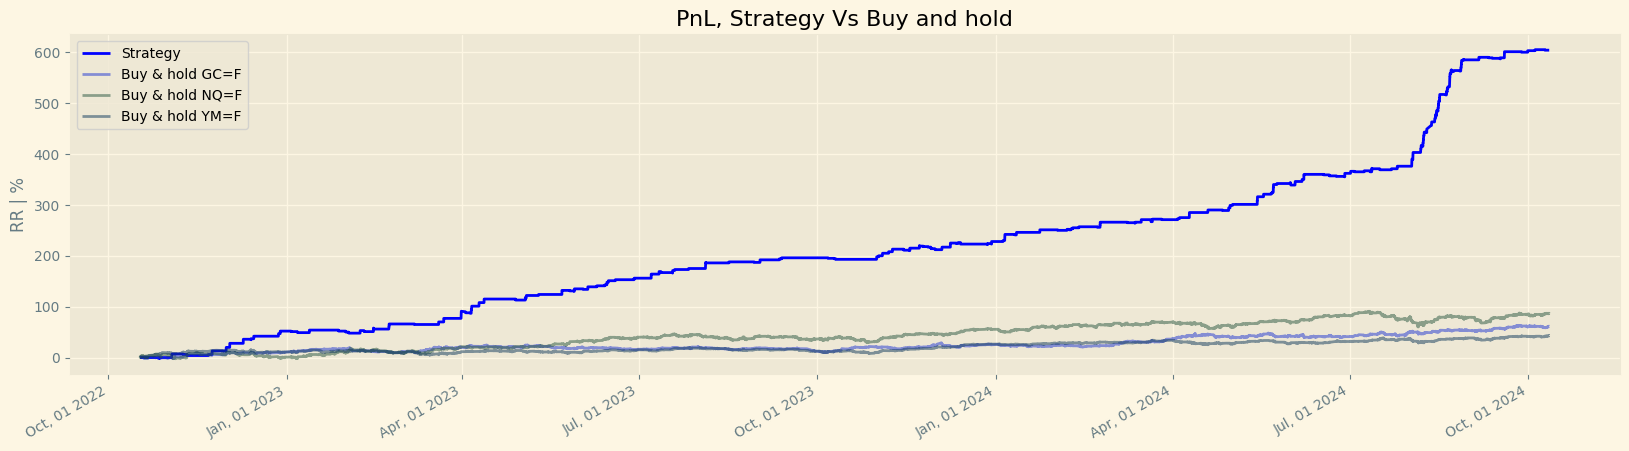

In [13]:
# Plot the Strategy returns
def plot_pnl():
    _pnl_df = df['Cumulative_PnL']
    _pnl_df.index = [dt for (dt, _) in df.index.tolist()]
    _pnl_df.plot(
            label='Strategy', 
            figsize=(FIGSIZE['WIDTH'], 
            FIGSIZE['HEIGHT']), 
            color='blue', 
            xlabel='',
            ylabel='RR | %',
        )

plot_pnl()

# df.xs('GC=F', level=1)['Z-Score']

for tk, group_df in df.groupby(level=1):
    group_df.index = [dt for (dt, _) in group_df.index]
    starting_inv_price = group_df['close'].iloc[0]

    (100 * (group_df['close'] - starting_inv_price)/starting_inv_price).plot(
            label=f"Buy & hold {tk}", 
            figsize=(FIGSIZE['WIDTH'], 
            FIGSIZE['HEIGHT']), 
            color=generate_random_hex_color(), 
            xlabel='',
            alpha=.5,
            ylabel='RR | %'
        )

plt.title('PnL, Strategy Vs Buy and hold')
plt.legend()

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

- PnL drawdown

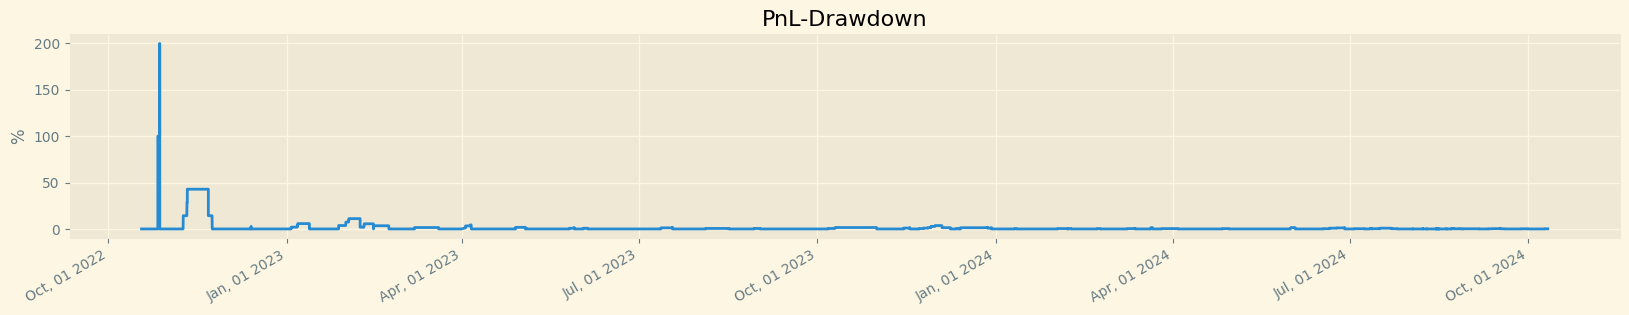

In [14]:
def plot_pnl_DD():
    peak = df['Cumulative_PnL'].cummax()
    _pnl_DD = pd.Series(
        data=np.where(peak == 0, abs(df['Cumulative_PnL']), (peak - df['Cumulative_PnL']) / peak).tolist(),
        index=peak.index
    )

    (_pnl_DD * 100).plot(
        kind='line', 
        figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2),
        title="PnL-Drawdown",
        ylabel="%",
        xlabel=''
    )

plot_pnl_DD()

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))

- Positions nature distribution

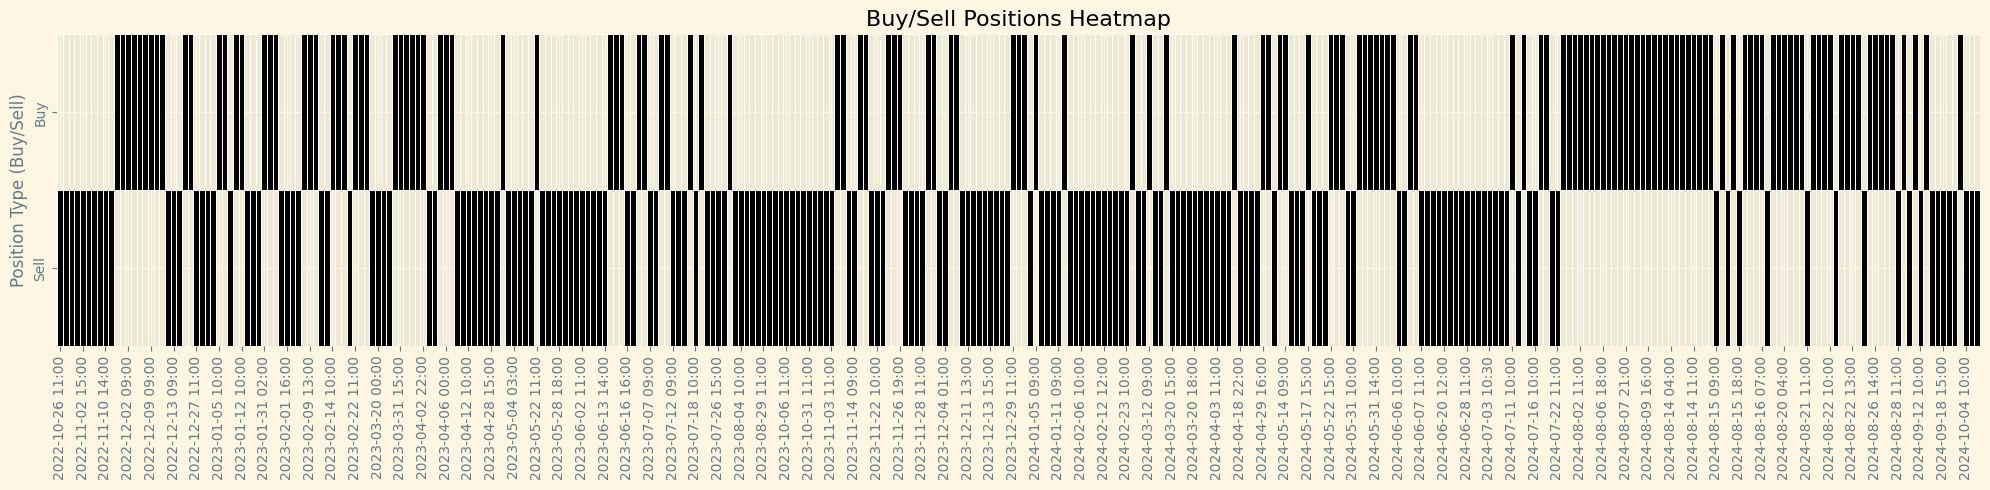

In [15]:
positions_df = pd.DataFrame(index=[dt for (dt, _) in df.index])
positions_df.index = positions_df.index.strftime('%Y-%m-%d %H:%M')

positions_df['Buy'] = np.where(df['Position'] > 0, df['Position'], 0) 
positions_df['Sell'] = np.where(df['Position'] < 0, abs(df['Position']), 0) 

positions_df = positions_df.loc[(positions_df['Buy'] != 0) | (positions_df['Sell'] != 0)]

# Plot heatmap
plt.figure(figsize=(FIGSIZE['WIDTH'], FIGSIZE['HEIGHT']))
sns.heatmap(positions_df.T, cmap=['#FFFFFF00', 'black'], cbar=False, linewidths=0.5)

# Customize labels and title
plt.title('Buy/Sell Positions Heatmap')
plt.xlabel('')
plt.ylabel('Position Type (Buy/Sell)')

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()